In [18]:
import torch
import torch.utils.data as data
from torchvision.utils import make_grid
import pandas as pd

In [19]:
from data import DigitsDateset
from models.digits_recognition_network import DigitsRecognizer, DigitsPredictor
from utils import multi_target_loss, sum_list_strs, show, TrainVisualizer

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [21]:
ds = DigitsDateset('train')
train_ds, valid_ds = data.random_split(ds, [0.8, 0.2])
net = DigitsRecognizer()
dl = data.DataLoader(dataset=ds, batch_size=16, shuffle=True)
train_dl = data.DataLoader(dataset=train_ds, batch_size=16, shuffle=True)
valid_dl = data.DataLoader(dataset=valid_ds, batch_size=16, shuffle=False)

In [23]:
optim = torch.optim.Adam(net.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.95)
visualizer = TrainVisualizer()

----START TRAINING----

epoch 1:
    iter: 10 train_loss: 2.1466482996940615
    iter: 20 train_loss: 1.6171390175819398
    iter: 30 train_loss: 1.388180673122406
    iter: 40 train_loss: 1.4255377173423767
    iter: 50 train_loss: 1.3410191774368285
    iter: 60 train_loss: 1.3674384713172913

    Accuracy: 0.0525

    Accuracy: 0.055

epoch 2:
    iter: 60 train_loss: 1.2348733782768249
    iter: 70 train_loss: 1.2625321745872498
    iter: 80 train_loss: 1.2679853320121766
    iter: 90 train_loss: 1.2216404795646667
    iter: 100 train_loss: 1.1967690348625184
    iter: 110 train_loss: 1.2225217044353485

    Accuracy: 0.05125

    Accuracy: 0.045

epoch 3:
    iter: 110 train_loss: 1.2405856132507325
    iter: 120 train_loss: 1.2390479564666748
    iter: 130 train_loss: 1.1875550866127014
    iter: 140 train_loss: 1.2296757340431212
    iter: 150 train_loss: 1.153643000125885
    iter: 160 train_loss: 1.2325245261192321

    Accuracy: 0.055

    Accuracy: 0.06

epoch 4:
    iter: 1

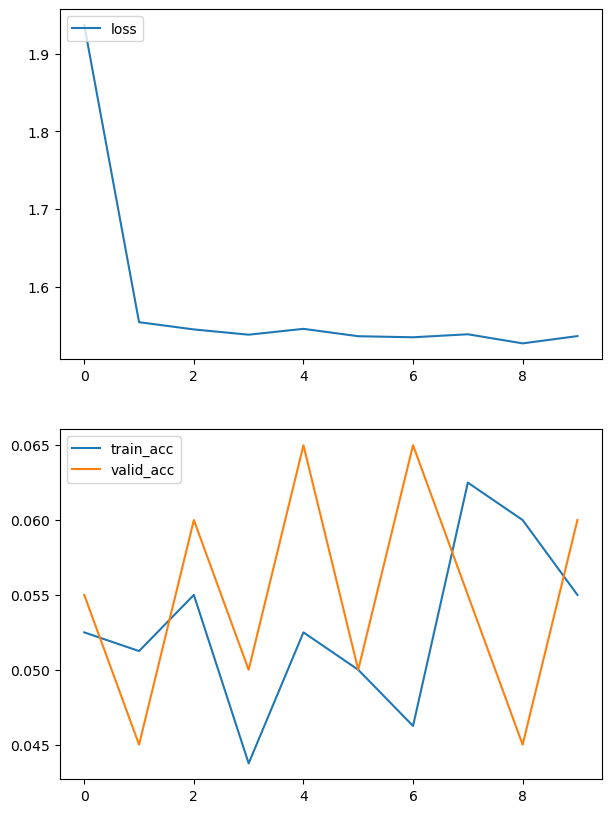

In [24]:
net.to(device)
num_epochs = 10
visualizer.reset()

def test_accuracy(test_model, data_loader, total_num):
    with torch.no_grad():
        net.eval()
        net.to(device)
        total_acc = 0
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            logits = test_model(X)
            total_acc += (logits.argmax(dim=2) == y).all(dim=1).sum()
        print(f'\n    Accuracy: {total_acc.item() / total_num}')
        return total_acc / total_num

print('----START TRAINING----')
for epoch in range(num_epochs):
    print(f'\nepoch {epoch + 1}:')
    net.train()
    epoch_loss = 0
    mean_loss = 0
    for i, (X, y) in enumerate(dl):
        optim.zero_grad()
        X, y = X.to(device), y.to(device)
        loss = multi_target_loss(y, net(X))
        loss.backward()
        optim.step()
        lr_scheduler.step()

        mean_loss += loss.item()
        epoch_loss += loss.item()
        if (i + 1) % 10 == 0:
            print(f'    iter: {epoch * len(train_dl) + i + 1} train_loss: {mean_loss / 10}')
            mean_loss = 0
    train_acc = test_accuracy(net, train_dl, len(train_ds))
    valid_acc = test_accuracy(net, valid_dl, len(valid_ds))
    visualizer.record(**{
        'epoch': epoch,
        'loss': epoch_loss / len(train_dl),
        'train_acc': train_acc.cpu().item(),
        'valid_acc': valid_acc.cpu().item(),
    })
print('-----END TRAINING-----')
visualizer.visualize(
    'epoch', ['loss', ['train_acc', 'valid_acc']]
)

In [11]:
# torch.save(net, ...)
from models.digits_recognition_network import *
net = torch.load('TrainedModels/DRN.pt')

In [17]:
with torch.no_grad():
    net.eval()
    net.to(device)
    test_ds = DigitsDateset('test')
    test_dl = data.DataLoader(test_ds, batch_size=16, shuffle=False)
    predictions = []
    for X in test_dl:
        X = X.to(device)
        logits = net(X)
        predictions += DigitsPredictor()(logits)

    # make submission file
    submission = pd.DataFrame(columns=['filename', 'result'])
    submission['filename'] = [f'test_{i + 1}.jpg' for i in range(500)]
    # TODO: add comments here
    submission['result'] = [sum_list_strs(list_strs)[-5:] for list_strs in predictions]
    submission.to_csv(f'./submission.csv', header=True, index=False)

In [16]:
submission['result'].sample(10)

267    00349
60     00535
5      00278
168    00541
305    00997
37     00198
396    00047
293    00520
493    00314
437    00372
Name: result, dtype: object